In [21]:
import numpy as np
import tifffile as tf
%pylab inline
import math
from scipy import ndimage
import time
from sklearn import preprocessing 
from random import randint
from sklearn.svm import SVC

Populating the interactive namespace from numpy and matplotlib


C:\Users\bruno\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
def criar_pad (img):
    kernel = np.ones((15,15))
    m, n = kernel.shape
    pdy, pdx = int(m/2), int(n/2)
    img_alt = img.copy()
    img_alt[np.where(img_alt==0)] = 1  
    img_pad = np.pad(img_alt,((pdx, pdx), (pdy, pdy)), mode='constant', constant_values=1) 

    return img_pad


In [23]:
def linhas(ang):
    angr=math.radians(ang)
    m = math.tan(angr)
    xx=np.zeros(15, dtype=int)
    yy=np.zeros(15, dtype=int)
    for i in range (15):
        i+=1
        if ang <= 45 or ang >= 135: 
            y = ((-8*m) + 8) + m*i
            i-=1
            xx[i] = int(round(y)-1)
            yy[i] = int(i)    

        else:
            x = ((i-8)/m) + 8
            i-=1
            xx[i] = int(i)
            yy[i] = int(round(x)-1)

    return xx, yy

linhas(165) #Exibir as coordenadas da linha de ângulo 165º

(array([9, 9, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [24]:
def orto(ang): #, tamanho): #Desenvolvida para o caso de se ter 
    tam = 3
    angr=math.radians(ang)
    m = math.tan(angr)  
    xx=np.zeros(tam, dtype=int)
    yy=np.zeros(tam, dtype=int)
    x, y = 15//2, 15//2
    
    xx[0] = x
    yy[0] = y
    
    if ang < 22.5 or ang > 157.5: #Nesta condição tem de se fazer ângulo de 90º
        xx[1]=6
        xx[2]=8
        yy[1]=7
        yy[2]=7
        
    if ang > 22.5 and ang < 67.5: #Nesta condição tem de se fazer ângulo de 135º
        xx[1]=6
        xx[2]=8
        yy[1]=6
        yy[2]=8

    if ang > 67.5 and ang < 112.5: #Nesta condição tem de se fazer ângulo de 0º
        xx[1]=7
        xx[2]=7
        yy[1]=6
        yy[2]=8        

    if ang > 112.5 and ang < 157.5: #Nesta condição tem de se fazer ângulo de 45º
        xx[1]=6
        xx[2]=8
        yy[1]=8
        yy[2]=6


    return xx, yy

orto(165) #Exibir a ortogonal feita aquando um ângulo de 165º

(array([7, 6, 8]), array([7, 7, 7]))

In [25]:
#===Aplicação do transformação normal no array===#
def transf_normal(ar):
    x,y=ar.shape
    media=ar.mean()
    desvio=ar.std()    
    for i in range (x):
        for j in range(y):
            if desvio !=0 :
                ar[i,j]=((ar[i,j]-media)/desvio)
            
    return ar

TEMPO_main:--- 31.548107624053955 seconds ---


Text(0.5, 1.0, 'I')

<Figure size 432x288 with 0 Axes>

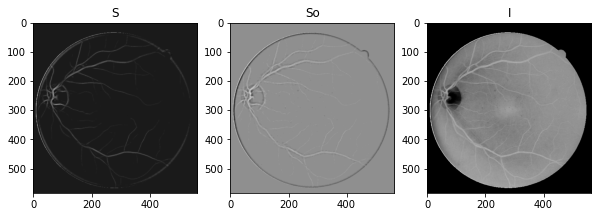

In [26]:
def main(img, img_mask):
    start_time = time.time()
    #===Iniciar imagem como float, canal verde e fazer padding===#
    img = img.astype(float)
    img=img[:,:,1]
    img = criar_pad(img)
    gray()
    img0 = 255 - img #Inversão da imagem
    
    #======MÁSCARA DOS VASOS======#
    img_msk1 = img_mask
    img_msk = criar_pad(img_msk1)

    line,col =img0.shape  
    kernel = np.ones((15,15))
    m, n = kernel.shape
    pdy, pdx = int(m/2), int(n/2)
    
    #==Abrir variaveis com as coord==#
    l0,c0 = linhas(0)    
    l15,c15 = linhas(15)
    l30,c30 = linhas(30)
    l45,c45 = linhas(45)
    l60,c60 = linhas(60)
    l75,c75 = linhas(75)
    l90,c90 = linhas(90)
    l105,c105 = linhas(105)
    l120,c120 = linhas(120)
    l135,c135 = linhas(135)
    l150,c150 = linhas(150)
    l165,c165 = linhas(165)
    
    lort0,cort0 = orto(0) 
    lort15,cort15 = orto(15)
    lort30,cort30 = orto(30)
    lort45,cort45 = orto(45)
    lort60,cort60 = orto(60)
    lort75,cort75 = orto(75)
    lort90,cort90 = orto(90)
    lort105,cort105 = orto(105)
    lort120,cort120 = orto(120)
    lort135,cort135 = orto(135)
    lort150,cort150 = orto(150)
    lort165,cort165 = orto(165)
    
    L=np.zeros_like(img0)
    Lo=np.zeros_like(img0)
    N=np.zeros_like(img0)
    I = np.zeros_like(img0)
    

    for l in range (pdy, line-pdy):
        for c in range (pdx, col-pdx):
            if (img_msk[l,c] == 255): #fazer apenas os valores que estão nos vasos da retina
                kernel_msk = img_msk[l-pdy:l+pdy+1, c-pdx:c+pdx+1]
                kernel_img = img0[l-pdy:l+pdy+1, c-pdx:c+pdx+1]
                
                if not kernel_msk.all():
                    kernel_img[kernel_msk == 0] = kernel_img[kernel_msk == 255].mean()                          
                    
                #========Calculo para S, So========#
                N[l,c] = np.mean(kernel_img)
                kernel1 = kernel_img
                linha0= kernel1[l0,c0].mean()
                linha15 = kernel1[l15,c15].mean()
                linha30 = kernel1[l30,c30].mean()
                linha45 = kernel1[l45,c45].mean()
                linha60 = kernel1[l60,c60].mean()
                linha75 = kernel1[l75,c75].mean()
                linha90 = kernel1[l90,c90].mean()
                linha105 = kernel1[l105,c105].mean()
                linha120 = kernel1[l120,c120].mean()
                linha135 = kernel1[l135,c135].mean()
                linha150 = kernel1[l150,c150].mean()
                linha165 = kernel1[l165,c165].mean()
                
                #===================AGRUPAR OS DADOS====================#
                Ll = np.array([linha0, linha15, linha30, linha45, linha60, linha75, linha90, linha105, linha120, linha135, linha150, linha165])
                ind_coordORT = np.argmax(Ll) #Diz o índice onde aparece o máximo
                L[l,c]= max(Ll)  #FAZER S
                angs = np.array([[lort0,cort0],[lort15,cort15],[lort30,cort30],[lort45,cort45],[lort60,cort60],[lort75,cort75], [lort90,cort90],[lort105,cort105],[lort120,cort120],[lort135,cort135],[lort150,cort150],[lort165,cort165]])
                # O So é feito para a linha com o Smáx e faz as linhas ortogonais
                coordSo = angs[ind_coordORT]
                Lo[l,c] = kernel1[coordSo[0],coordSo[1]].mean()
                I[l,c]= img0[l,c] #FAZER OS I (Intensidades da imagem invertida)
                
    #=======Criação das imagens correspondentes S,So,I=======#      
    S=transf_normal(L.astype(np.int32)-N.astype(np.int32))   
    So=transf_normal(Lo.astype(np.int32)-N.astype(np.int32))  
    I=transf_normal(I)
    
    S= S[pdy:line-7,pdx: col-7]   #Retirar o pad
    So= So[pdy:line-7,pdx: col-7]
    I= I[pdy:line-7,pdx: col-7]

    vetorx=np.array([S,So,I])
    print("TEMPO_main:--- %s seconds ---" % (time.time() - start_time)) 
    return vetorx


#========Exibir um exemplo das imagens de S, So e I obtidas========#
img = tf.imread('DRIVE/training/images/21_training.tif')
mask = imread('DRIVE/training/mask/21_training_mask.gif')
vetorx = main(img,mask)


_, ax= subplots(1,3, figsize=(10,10))
ax[0].imshow(vetorx[0])
ax[1].imshow(vetorx[1])
ax[2].imshow(vetorx[2])

ax[0].set_title('S')
ax[1].set_title('So')
ax[2].set_title("I")
    

In [27]:
start_time = time.time()
imagens=[]
vasos=[]
mascaras=[]

imagens_teste=[]
vasos_teste=[]
mascaras_teste=[]

#=========CARREGAMENTO DAS IMAGENS DE DRIVE=========#

for i in range (21,41): #carregar a sequência de 3 imagens de treino para uma lista
    ii=str(i)
    vaso=imread('C:/Users/bruno/jup/Trabalho/Drive/training/1st_manual/'+ii+'_manual1.gif')
    imagem=tf.imread('C:/Users/bruno/jup/Trabalho/Drive/training/images/'+ii+'_training.tif')
    mascara=imread('C:/Users/bruno/jup/Trabalho/Drive/training/mask/'+ii+'_training_mask.gif')
    gray()
    imagens.append(imagem)
    vasos.append(vaso)
    mascaras.append(mascara)
    
for i in range (1,21):#carregar a sequência de 3 imagens de teste para listas
    k=str(i) 
    ii=k.zfill(2) #para preencher com zeros, devido ao nome das imagens ser,p.ex, 01 e não apenas 1
    vast=imread('C:/Users/bruno/jup/Trabalho/Drive/test/1st_manual/'+ii+'_manual1.gif')
    imagemt=tf.imread('C:/Users/bruno/jup/Trabalho/Drive/test/images/'+ii+'_test.tif')
    mascarat=imread('C:/Users/bruno/jup/Trabalho/Drive/test/mask/'+ii+'_test_mask.gif')
    gray()
    imagens_teste.append(imagemt)
    vasos_teste.append(vast)
    mascaras_teste.append(mascarat)
    

    

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Máscara Retina Teste')

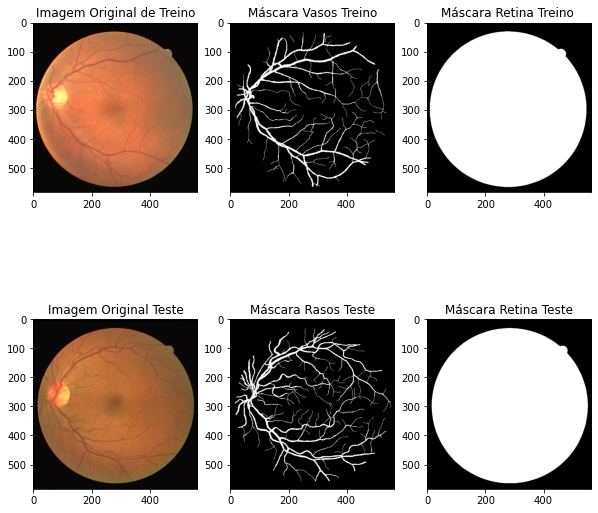

In [28]:
#====Exibição de um exemplo das imagens a utilizar====#
_, ax= subplots(2,3, figsize=(10,10))
ax[0,0].imshow(imagens[0])
ax[0,1].imshow(vasos[0])
ax[0,2].imshow(mascaras[0])
ax[1,0].imshow(imagens_teste[0])
ax[1,1].imshow(vasos_teste[0])
ax[1,2].imshow(mascaras_teste[0])

ax[0,0].set_title('Imagem Original de Treino')
ax[0,1].set_title('Máscara Vasos Treino')
ax[0,2].set_title('Máscara Retina Treino ')
ax[1,0].set_title('Imagem Original Teste')
ax[1,1].set_title('Máscara Rasos Teste')
ax[1,2].set_title('Máscara Retina Teste')
  

In [29]:
S_total=[]
So_total=[]
I_total=[]
S_total_teste=[]
So_total_teste=[]
I_total_teste=[]

#==GUARDAR OS VALORES DE S, S0 E I PARA AS IMAGENS E TREINO E TESTE==#

for i in range (len(imagens)):
    #treino
    Sf,Sof,If=main(imagens[i],mascaras[i])
    S_total.append(Sf)
    So_total.append(Sof)
    I_total.append(If)
    
    #teste
    Sft,Soft,Ift=main(imagens_teste[i],mascaras_teste[i])
    S_total_teste.append(Sft)
    So_total_teste.append(Soft)
    I_total_teste.append(Ift)




    

TEMPO_main:--- 40.522034645080566 seconds ---
TEMPO_main:--- 35.118937730789185 seconds ---
TEMPO_main:--- 33.87801742553711 seconds ---
TEMPO_main:--- 34.44648003578186 seconds ---
TEMPO_main:--- 36.340869426727295 seconds ---
TEMPO_main:--- 40.93013548851013 seconds ---
TEMPO_main:--- 38.31846070289612 seconds ---
TEMPO_main:--- 39.46811318397522 seconds ---
TEMPO_main:--- 39.31988716125488 seconds ---
TEMPO_main:--- 39.565982818603516 seconds ---
TEMPO_main:--- 38.996063232421875 seconds ---
TEMPO_main:--- 41.010820627212524 seconds ---
TEMPO_main:--- 40.031898021698 seconds ---
TEMPO_main:--- 40.143336057662964 seconds ---
TEMPO_main:--- 40.44283866882324 seconds ---
TEMPO_main:--- 41.07906723022461 seconds ---
TEMPO_main:--- 40.1979341506958 seconds ---
TEMPO_main:--- 43.822017669677734 seconds ---
TEMPO_main:--- 40.75105428695679 seconds ---
TEMPO_main:--- 40.391972064971924 seconds ---
TEMPO_main:--- 40.69288182258606 seconds ---
TEMPO_main:--- 41.36108994483948 seconds ---
TEMP

<Figure size 432x288 with 0 Axes>

In [30]:
#==Extração de apenas 1000 pixeis de cada imagem de forma aleatória==#
#====Agrupar I,S e So em diversos grupos de 3 (tabela de features)====#
def extrai_pixeis(I,S,S0,V,mask):
    data=[]
    label=[]
    linha=[]
    for i in range(len(I)):
        inv=I[i]
        s=S[i]
        s0=S0[i]
        v=V[i]
        m=mask[i]
        j=0    
        while j<1000:       
            a=randint(0,583)
            b=randint(0,564)
            if m[a,b]>0:    #Garante a escolha de pontos no interior da retina
                linha=[inv[a,b],s[a,b],s0[a,b]]
                data.append(linha)
                label.append(v[a,b])
                j=j+1
            
    return (data,label)
    

In [31]:
#=================Guardar os valores de I, S e So das imagens de teste==================#  
#==agrupando estas características em conjuntos de 3 (criação da tabela de features)==#  
def data_t(I,S,S0,V,M):
    data=[]
    label=[]
    for i in range (I.shape[0]):
        for j in range(I.shape[1]):
            if M[i,j]>0:
                linha=[I[i,j],S[i,j],S0[i,j]]
                data.append(linha)
                label.append(V[i,j])
    return(data,label)

In [32]:
def SVM(I_total,S_total,So_total,vasos,mascaras,I_total_teste,S_total_teste,So_total_teste,vasos_teste,mascaras_teste):
    soma_teste=[]
    soma_esp=[]
    soma_ex=[]
    soma_sens=[]
    imagens=[]
    
    data,label=extrai_pixeis(I_total,S_total,So_total,vasos,mascaras)
    clf=SVC(kernel='rbf') #Utilizar o kernel de função de base radial
    clf=clf.fit(data,label)
    pred_train=clf.predict(data)
    ts_rbf=np.mean(pred_train==label)*100 #Accuracy do treino
    
    for i in range (len(I_total_teste)): #Fazer para cada imagem de teste
        start_time = time.time()
        data_teste,label_teste=data_t(I_total_teste[i],S_total_teste[i],So_total_teste[i],vasos_teste[i],mascaras_teste[i])
        
        pred_test=clf.predict(data_teste)
        ts_accuracy=np.mean(pred_test==label_teste)*100
        soma_teste.append(ts_accuracy)
    
        img= reconstrucao(pred_test,I_total[i],mascaras_teste[i])
        s,e,ex=metricas(img, vasos_teste[i],mascaras_teste[i])
        soma_esp.append(e)
        soma_sens.append(s)
        soma_ex.append(ex)
        imagens.append(img)
        imshow(img)
        show()
        print("TEMPO_SVM:--- %s seconds ---" % (time.time() - start_time))
    
    accuracy_teste=np.mean(soma_teste,dtype=np.float32)  #Média dos Testes
    accuracy_esp=np.mean(soma_esp,dtype=np.float32)      #Média das Sensibilidades
    accuracy_sens=np.mean(soma_sens,dtype=np.float32)    #Média das Especificidades
    accuracy_ex=np.mean(soma_ex,dtype=np.float32)        #Média das Exatidões
    print('Accuracy do treino(rbf):',ts_rbf,'\\ e média do teste:',accuracy_teste)
    print('Média Sensibilidade:',accuracy_sens,' \\Média Especificidade',accuracy_esp,' Média Exatidão:',accuracy_ex)
    
    

In [33]:
#==Construção da imagem prevista==#
def reconstrucao(pred_test,I,M):
    c=0
    img=np.zeros_like(I) #O background vai ficar a preto (0)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if M[i,j]>0:    #Colectar os pixeis que pertencem ao fundus da retina
                img[i,j]=pred_test[c] #Altera os pixeis de img para os valores do predict
                c+=1
    return(img)


In [34]:
def metricas(img, vasos, mask):
    VP=0
    FP=0
    VN=0
    FN=0            
    for i in range (img.shape[0]):
        for j in range (img.shape[1]):
            if mask[i,j]!=0:           #Verificar se está dentro do fundus da retina
                if img[i,j]==0:        #Se é considerado que este pixel é vaso
                    if vasos[i,j]==0:  #Se não pertence a um vaso, soma-se um Verdadeiro Negativo
                        VN+=1         
                    else:              #Se pertence, soma-se um Falso Negativo
                        FN+=1
                else:                  #Se o pixel não foi considerado como vaso 
                    if vasos[i,j]==0:  #Verifica-se se este não pertence a um vaso, se sim soma-se um Falso Positivo
                        FP+=1               
                    else:              #Se pertence a um vaso, soma-se um Verdadeiro Positivo
                        VP+=1            
    sens=VP/(VP+FN)
    esp=VN/(VN+FP)
    exa=(VP+VN)/(VP+VN+FP+FN)
    return(sens,esp,exa)


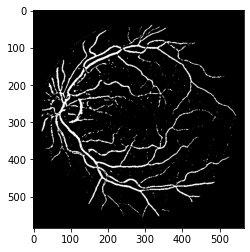

TEMPO_SVM:--- 15.265469312667847 seconds ---


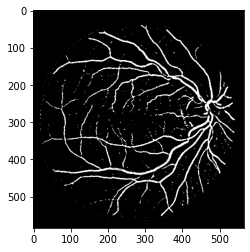

TEMPO_SVM:--- 15.08615493774414 seconds ---


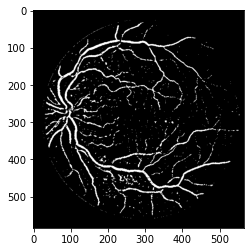

TEMPO_SVM:--- 15.795199871063232 seconds ---


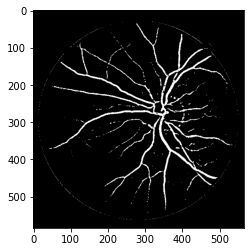

TEMPO_SVM:--- 14.934946298599243 seconds ---


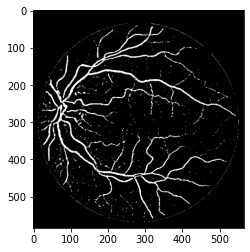

TEMPO_SVM:--- 14.655486345291138 seconds ---


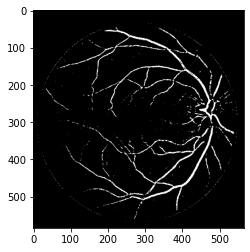

TEMPO_SVM:--- 15.18901014328003 seconds ---


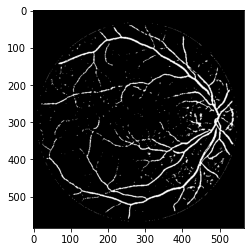

TEMPO_SVM:--- 14.708287715911865 seconds ---


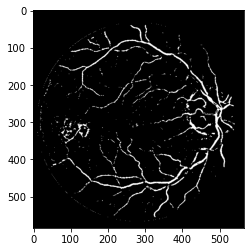

TEMPO_SVM:--- 14.077393054962158 seconds ---


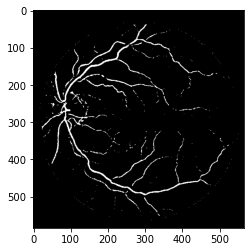

TEMPO_SVM:--- 14.42542314529419 seconds ---


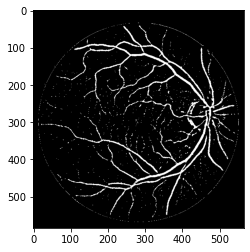

TEMPO_SVM:--- 14.409424304962158 seconds ---


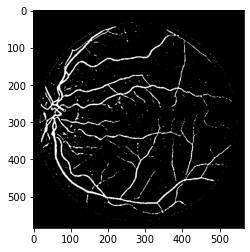

TEMPO_SVM:--- 14.322734117507935 seconds ---


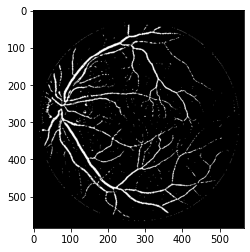

TEMPO_SVM:--- 14.338656425476074 seconds ---


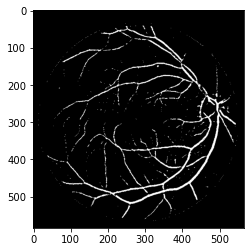

TEMPO_SVM:--- 14.557069540023804 seconds ---


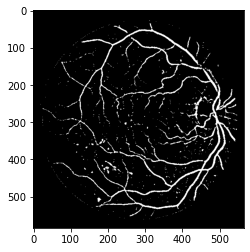

TEMPO_SVM:--- 14.330640077590942 seconds ---


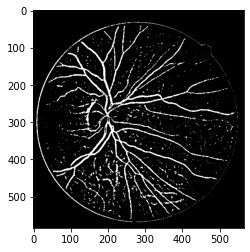

TEMPO_SVM:--- 14.385529518127441 seconds ---


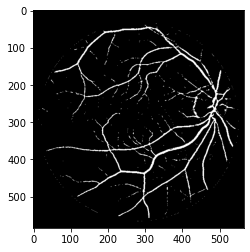

TEMPO_SVM:--- 14.23792290687561 seconds ---


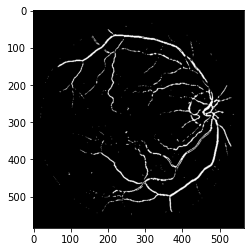

TEMPO_SVM:--- 14.143217325210571 seconds ---


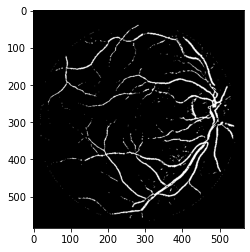

TEMPO_SVM:--- 14.237884998321533 seconds ---


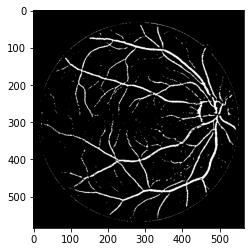

TEMPO_SVM:--- 14.505211353302002 seconds ---


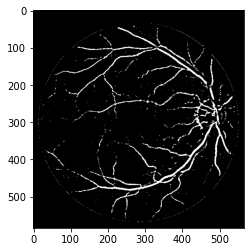

TEMPO_SVM:--- 14.590018272399902 seconds ---
Accuracy do treino(rbf): 93.07 \ e média do teste: 92.885155
Média Sensibilidade: 0.527563  \Média Especificidade 0.9876747  Média Exatidão: 0.9288515


In [35]:
SVM(I_total,S_total,So_total,vasos,mascaras,I_total_teste,S_total_teste,So_total_teste,vasos_teste,mascaras_teste)

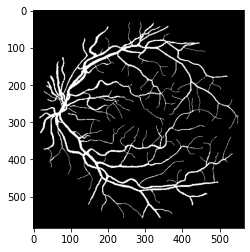

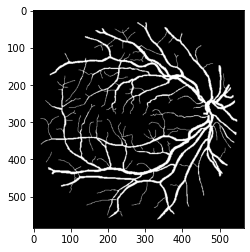

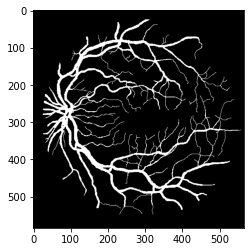

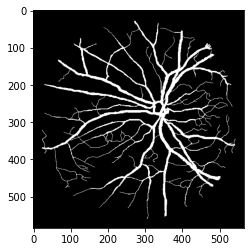

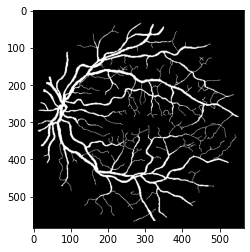

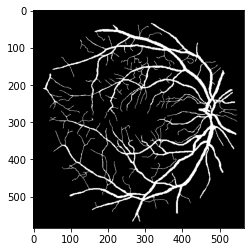

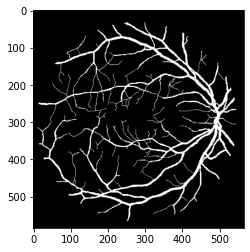

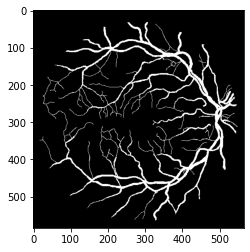

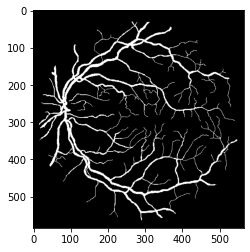

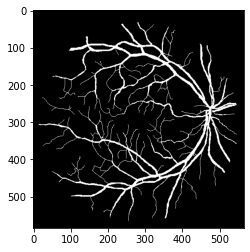

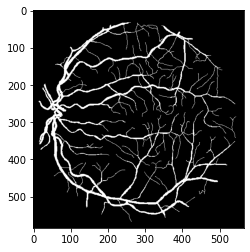

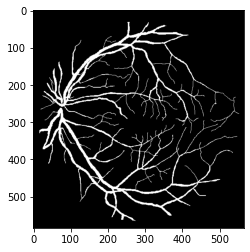

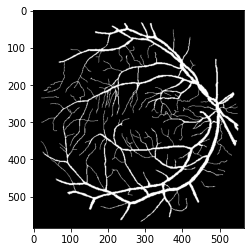

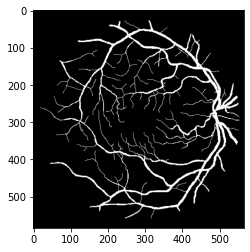

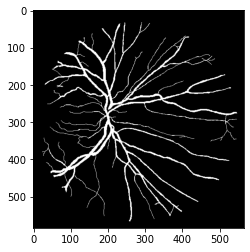

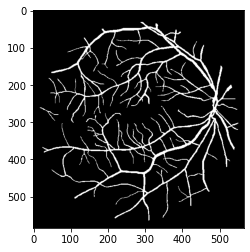

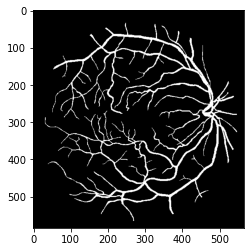

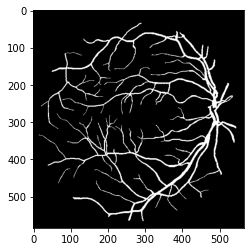

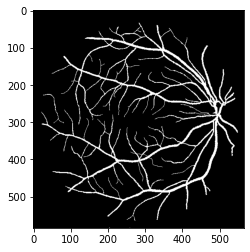

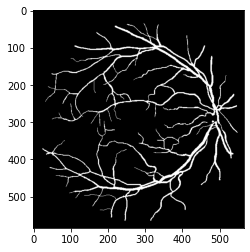

In [36]:
for i in range(20):
    imshow(vasos_teste[i])
    show()